In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
# importing iowa shapefile
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')  
# shapefile_iowa.head()

# viewing a few key columns, first few rows
shapefile_iowa[['GEOID10','COUNTYFP10','NAME10','INTPTLAT10', 'INTPTLON10', 'geometry' ]].head()

,GEOID10,COUNTYFP10,NAME10,INTPTLAT10,INTPTLON10,geometry
0,19127,127,Marshall,+42.0416910,-092.9814523,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19011,011,Benton,+42.0925474,-092.0576300,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19041,041,Clay,+43.0798220,-095.1497261,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19165,165,Shelby,+41.6790143,-095.3089173,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19043,043,Clayton,+42.8409979,-091.3235108,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


### six county subdivision test case (not needed for compiling full)

Text(0.5, 1.0, 'Six Counties Near Des Moines')

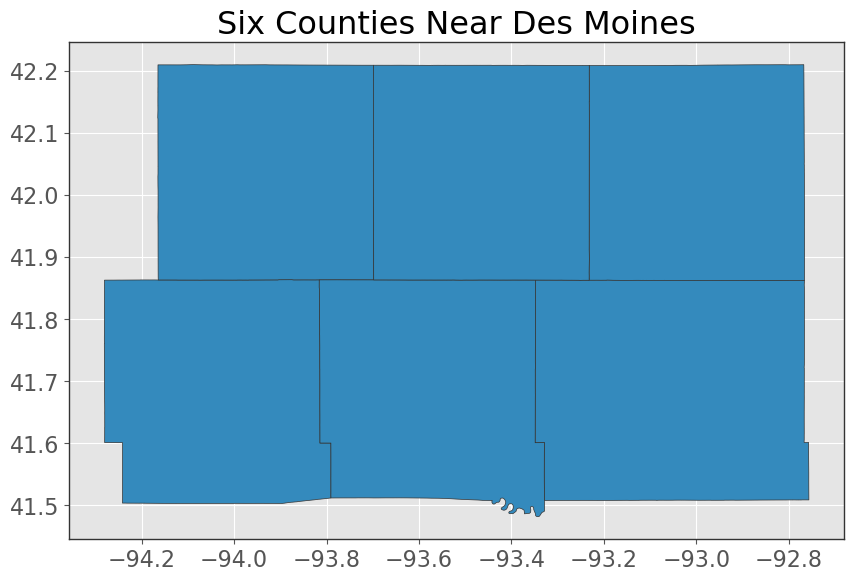

In [7]:
# making a six county subset of the shapefile to test operations on

#for the basic plots (won't work with our main package import; should fix this sometime)
##### from https://www.tomasbeuzen.com/python-for-geospatial-analysis/chapters/chapter1_intro-to-spatial.html
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.edgecolor': '0.2'})



sixcounties=shapefile_iowa.loc[shapefile_iowa['NAME10'].isin(['Boone','Story','Marshall','Dallas','Polk','Jasper'])].copy()
sixcounties.plot(edgecolor="0.2",figsize=(10,8))
plt.title("Six Counties Near Des Moines")

In [8]:
# listing the 6 counties
sixcounties[['NAME10', 'geometry']]

,NAME10,geometry
0,Marshall,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
41,Dallas,"POLYGON ((-94.28050 41.68833, -94.28050 41.688..."
52,Boone,"POLYGON ((-94.16462 42.03460, -94.16463 42.035..."
54,Jasper,"POLYGON ((-92.76643 41.68812, -92.76643 41.686..."
73,Polk,"POLYGON ((-93.44129 41.50759, -93.44210 41.507..."
95,Story,"POLYGON ((-93.58088 41.86322, -93.58091 41.863..."


In [9]:
boone = sixcounties.iloc[[2]]
boone

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
52,19,015,19015,Boone,Boone County,1480356844,5364798,+42.0386005,-093.9391375,26306,...,14388,7512,6556,320,14196,5541,7484,1171,4,"POLYGON ((-94.16462 42.03460, -94.16463 42.035..."


documentation on intersects: https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html#geopandas.GeoSeries.intersects

unary union necessary to test against all geometries, rather than element-wise matching. See: https://stackoverflow.com/questions/30405652/how-to-find-which-points-intersect-with-a-polygon-in-geopandas


In [10]:
# boone county has index 2 in the six county subset. this intersects operation should find all polygons which "intersect" with BBBBBoone.
# result: counties 41, 52, 73, 95 (Dallas, Boone, Polk, Story) all "intersect" Boone.
#   counties 0 and 54 (Marshall and Jasper) don't

sixcounties.intersects(sixcounties.iloc[[2]].unary_union)

0     False
41     True
52     True
54    False
73     True
95     True
dtype: bool

In [11]:
# making an adjacency matrix for our six county subset:


n_counties = 6

adjmat_temp = pd.DataFrame()

for j in range(n_counties):
    adjmat_temp[j] = sixcounties.intersects(sixcounties.iloc[[j]].unary_union)

adjmat_temp
    

,0,1,2,3,4,5
0,True,False,False,True,False,True
41,False,True,True,False,True,False
52,False,True,True,False,True,True
54,True,False,False,True,True,True
73,False,True,True,True,True,True
95,True,False,True,True,True,True


In [12]:
# converting the boolean to 0s and 1s

adjmat_temp = adjmat_temp.astype(int)
adjmat_temp

,0,1,2,3,4,5
0,1,0,0,1,0,1
41,0,1,1,0,1,0
52,0,1,1,0,1,1
54,1,0,0,1,1,1
73,0,1,1,1,1,1
95,1,0,1,1,1,1


### full statewide adjacency matrix (and testing)

In [3]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

n_counties = 99

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)

ia_adjac_matrix = ia_adjac_matrix.astype(int)

In [4]:
# first row of the full adjacency matrix is for Marshall County (since it is indexed first in original shapefile_iowa)

ia_adjac_matrix[[0]]

,0
0,1
1,0
2,0
3,0
4,0
...,...
94,0
95,1
96,1
97,0


In [5]:
# vector of counties which border county 0 (Marshall)
marshall_boolean = ia_adjac_matrix[[0]] == 1

# pulling corresponding rows from original shapefile df:
shapefile_iowa.loc[marshall_boolean.values, ['GEOID10','COUNTYFP10','NAME10','INTPTLAT10', 'INTPTLON10', 'geometry' ]]

,GEOID10,COUNTYFP10,NAME10,INTPTLAT10,INTPTLON10,geometry
0,19127,127,Marshall,+42.0416910,-092.9814523,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
54,19099,099,Jasper,+41.6856863,-093.0529712,"POLYGON ((-92.76643 41.68812, -92.76643 41.686..."
63,19083,083,Hardin,+42.3899554,-093.2410810,"POLYGON ((-93.14458 42.55674, -93.14373 42.556..."
83,19171,171,Tama,+42.0748481,-092.5294115,"POLYGON ((-92.76631 42.03504, -92.76632 42.036..."
86,19157,157,Poweshiek,+41.6845262,-092.5228819,"POLYGON ((-92.41560 41.86251, -92.41028 41.862..."
95,19169,169,Story,+42.0375379,-093.4660934,"POLYGON ((-93.58088 41.86322, -93.58091 41.863..."
96,19075,075,Grundy,+42.4033232,-092.7902613,"POLYGON ((-93.00290 42.47064, -93.00393 42.470..."
